In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split

import warnings
warnings.filterwarnings('ignore')

## 1 Data Preparation

In [2]:
df = pd.read_csv('data/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
pd.DataFrame(df['Class'].value_counts())

,Class
0,284315
1,492


In [6]:
print('Fraud proportion takes up {}%'.format(round(df['Class'].value_counts().values[1]/len(df['Class']) * 100, 4)))

Fraud proportion takes up 0.1727%


## 2 Data Processing 
### 2.1 Data Splitting and Standardizatioin

In [7]:
X = df.drop('Class', axis = 1)
y = df.Class

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

In [8]:
X_train

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
68806,53150.0,-1.115047,1.035583,0.800712,-1.060398,0.032621,0.853422,-0.614243,-3.231161,1.539948,...,-0.644896,3.020385,-0.539618,0.033156,-0.774946,0.105868,-0.430853,0.229737,-0.070591,12.95
40018,40060.0,1.228473,-0.138826,0.473795,-0.166381,-0.453564,-0.190135,-0.355309,0.048598,0.128943,...,0.032481,-0.172147,-0.574730,0.036834,-0.303782,0.073315,0.810356,-0.069178,0.001890,25.57
250360,154865.0,1.926148,-0.198628,-0.286727,1.596852,-0.488963,-0.311405,-0.303207,0.035513,1.301312,...,-0.355216,-0.528432,-1.251300,0.455607,-0.120530,-0.361515,-1.099295,0.052747,-0.032622,6.90
234820,148130.0,2.046232,0.196183,-1.704650,0.530027,0.177496,-1.443091,0.255403,-0.365759,0.602945,...,-0.216247,0.201104,0.757245,-0.013600,-0.079318,0.234805,-0.098151,0.000028,-0.031675,4.55
10001,15014.0,-0.837077,1.034710,2.333129,3.103776,0.229143,0.501123,0.314283,-0.161583,0.409634,...,-0.134542,-0.363839,-0.458101,0.164097,0.234167,-0.418734,-0.074078,-0.355165,-0.169616,3.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211543,138459.0,-1.321976,1.138686,-0.940861,0.154160,0.109802,-0.538822,0.490058,0.513762,-0.493834,...,-0.436962,-0.012778,-0.237503,0.008713,-0.767844,-0.397162,0.316379,-0.463125,-0.010589,49.89
86293,61167.0,-0.627810,0.918729,1.478453,0.213171,0.933695,1.261486,0.504752,0.404286,-0.939740,...,0.088281,-0.051356,-0.004245,0.090535,-0.964599,-0.522294,0.296733,0.145939,0.110400,24.99
122579,76616.0,1.512602,-0.949435,-0.219062,-1.638850,-0.856348,-0.465996,-0.669193,-0.135566,-2.284345,...,-0.279028,-0.558803,-1.377240,0.080444,-0.579511,0.297851,-0.495367,-0.001415,0.003665,34.90
152315,97253.0,1.798863,-1.699791,-0.142182,-0.619533,-1.570248,0.083268,-1.501980,0.176287,1.755507,...,0.146098,0.181914,0.351358,0.115638,-0.566188,-0.596200,-0.295152,-0.033616,-0.032471,171.31


In [9]:
def standardization(df, name):
    new_name = name+'_stand'
    df[new_name]= (df[name] - df[name].mean()) / df[name].std()
    
    return df

# Standardize the X_train dataset
features_lst = X.columns
for i in features_lst:
    standardization(X_train, i)

In [10]:
def standardize_test(x_train, x_test, name):
    new_name = name+'_stand'
    x_test[new_name]= (x_test[name] - x_train[name].mean()) / x_train[name].std()
    
    return x_test

# Standardize the X_test dataset
for j in features_lst:
    standardize_test(X_train, X_test, j)

In [11]:
X_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20_stand,V21_stand,V22_stand,V23_stand,V24_stand,V25_stand,V26_stand,V27_stand,V28_stand,Amount_stand
68806,53150.0,-1.115047,1.035583,0.800712,-1.060398,0.032621,0.853422,-0.614243,-3.231161,1.539948,...,-0.845456,4.094562,-0.742968,0.053657,-1.281471,0.202897,-0.892781,0.573777,-0.219661,-0.305116
40018,40060.0,1.228473,-0.138826,0.473795,-0.166381,-0.453564,-0.190135,-0.355309,0.048598,0.128943,...,0.040144,-0.233752,-0.791284,0.059559,-0.503032,0.140397,1.682648,-0.170915,0.006314,-0.254236
250360,154865.0,1.926148,-0.198628,-0.286727,1.596852,-0.488963,-0.311405,-0.303207,0.035513,1.301312,...,-0.466729,-0.716789,-1.722295,0.731667,-0.200270,-0.694475,-2.279754,0.132840,-0.101283,-0.329507
234820,148130.0,2.046232,0.196183,-1.704650,0.530027,0.177496,-1.443091,0.255403,-0.365759,0.602945,...,-0.285041,0.272288,1.041612,-0.021385,-0.132181,0.450456,-0.202445,0.001499,-0.098331,-0.338981
10001,15014.0,-0.837077,1.034710,2.333129,3.103776,0.229143,0.501123,0.314283,-0.161583,0.409634,...,-0.178220,-0.493640,-0.630794,0.263810,0.385746,-0.804335,-0.152495,-0.883399,-0.528389,-0.342045


In [12]:
X_test.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20_stand,V21_stand,V22_stand,V23_stand,V24_stand,V25_stand,V26_stand,V27_stand,V28_stand,Amount_stand
183484,125821.0,-0.323334,1.057455,-0.048341,-0.607204,1.259821,-0.091761,1.159101,-0.124335,-0.174640,...,0.241390,-0.281137,-0.597478,-0.419432,-0.078210,0.405734,0.018428,0.271723,0.502804,-0.196060
255448,157235.0,-0.349718,0.932619,0.142992,-0.657071,1.169784,-0.733369,1.009985,-0.071069,-0.302083,...,-0.128488,-0.368501,-1.146970,-0.048283,0.808480,-0.777611,0.279979,0.192837,0.547770,-0.349343
244749,152471.0,-1.614711,-2.406570,0.326194,0.665520,2.369268,-1.775367,-1.139049,0.329904,0.903813,...,0.546571,0.950569,1.560728,1.549302,1.057868,-3.460190,-2.159031,0.714656,1.363857,0.029712
63919,50927.0,-2.477184,0.860613,1.441850,1.051019,-1.856621,2.078384,0.510828,-0.243399,-0.260691,...,-1.293755,1.098359,0.952167,0.241378,-0.431981,0.009582,-0.367809,-1.269292,-2.058918,0.884421
11475,19899.0,1.338831,-0.547264,0.737389,-0.212383,-1.110039,-0.525744,-0.801403,-0.063672,0.997276,...,-0.168191,-0.189403,-0.103232,0.108062,0.549235,0.727477,-0.556336,-0.005469,0.010621,-0.337167


### 2.1 Handeling Imbalanced Dataset Methods
**SMOTE**: 

In [13]:
# # SMOTE
# sm = SMOTE(random_state = 0)
# X_sampled_smote, y_sampled_smote = sm.fit_resample(X_train, y_train)
# # X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_sampled_smote, y_sampled_smote, test_size = 0.2, random_state = 0)

# print("Before performing smote : ", Counter(y_train))
# print("After performing smote : ", Counter(y_sampled_smote))

## Supervised Learning 
**Logistic Regression** - ysy <br>
**K-Nearest Neighbors** - mql <br>
**Decision Tree** <br>
**Random Forest** - isha <br>
**Support Vector Machine Classifier (SVC)** <br>
**AdaBoost** <br>
**Gradient Boosting Classifier** - zzy <br>

Later, EDA and feature engineering are needed to add.

In [14]:
def confusion_matrix(test_y, pred_y):
    print("Classification accuracy is: \n", metrics.confusion_matrix(test_y, pred_y, normalize='all'))
    cf_matrix = metrics.confusion_matrix(test_y, pred_y)
    print("Confusion Matrix is: \n", cf_matrix)
    print("Classification report is: \n", classification_report(test_y, pred_y))
    
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=labels, fmt='', cmap='Blues')
    plt.title("Confusion Matrix with Normalization")
    plt.xlabel("Predicated Label")
    plt.ylabel("True Label")
    plt.show()

In [38]:
def model(features, model_classifier, model_name):
    print(model_name+' without using smote')
    model = model_classifier
    model.fit(X_train[features], y_train)
    
    y_pred = model.predict(X_test[features])
    y_pred_proba = model.predict_proba(X_test[features])[:, 1] # Keep probabilities for the positive outcome only
    
    confusion_matrix(y_test, y_pred)
    # Accuracy
    print("Accuracy (R^2) of Train Dataset: ", model.score(X_train[features], y_train))
    print("Accuracy (R^2) of Test Dataset: ", model.score(X_test[features], y_test))
    print('Accuracy score overall: ', metrics.accuracy_score(y_test, y_pred))
    print('Recall score is {}%'.format(round(metrics.recall_score(y_test, y_pred) * 100, 2)))
    
    print('\n'+model_name+' with using smote')
    smote_m = model_classifier
    
    # SMOTE
    pd_x_train, pd_x_test, pd_y_train, pd_y_test = train_test_split(X_train[features], y_train)
    sm = SMOTE(random_state = 0)
    X_sampled_smote, y_sampled_smote = sm.fit_resample(pd_x_train, pd_y_train)
    
    smote_m.fit(X_sampled_smote, y_sampled_smote)
    y_pred_smote = smote_m.predict(X_test[features])
    y_pred_proba_smote = smote_m.predict_proba(X_test[features])[:, 1]
    confusion_matrix(y_test, y_pred_smote)
    print('Validation test results:')
    print('Test Score:', smote_m.score(pd_x_test, pd_y_test))
    print('Accuracy Score:', metrics.accuracy_score(smote_m.predict(pd_x_test), pd_y_test))
    print('Recall Score:', metrics.recall_score(pd_y_test, smote_m.predict(pd_x_test)))
    
    print('\nTest Results:')
    print('Test Score:', smote_m.score(X_test[features], y_test))
    print('Accuracy Score:', metrics.accuracy_score(y_pred_smote, y_test))
    print('Recall Score:', metrics.recall_score(y_test, y_pred_smote))
    
    return y_pred, y_pred_proba, y_pred_smote, y_pred_proba_smote

In [39]:
def ROC(Y_test, Y_pred, Y_pred_prob, name):
    precision = metrics.precision_score(Y_test, Y_pred)
    recall = metrics.recall_score(Y_test, Y_pred)
    fprcat, tprcat, thresholds = metrics.roc_curve(Y_test, Y_pred_prob)
    AUC = metrics.auc(fprcat, tprcat)
    plt.figure(figsize=(5,4), dpi=256)
    plt.plot(fprcat, tprcat, 'b', label='AUC = %0.2f' % AUC)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    # plt.savefig(name + '.png')
    plt.show()

### Logistic Regression

Logistic Regression without using smote
Classification accuracy is: 
 [[9.98086444e-01 1.40444507e-04]
 [7.72444788e-04 1.00066711e-03]]
Confusion Matrix is: 
 [[56853     8]
 [   44    57]]
Classification report is: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.88      0.56      0.69       101

    accuracy                           1.00     56962
   macro avg       0.94      0.78      0.84     56962
weighted avg       1.00      1.00      1.00     56962



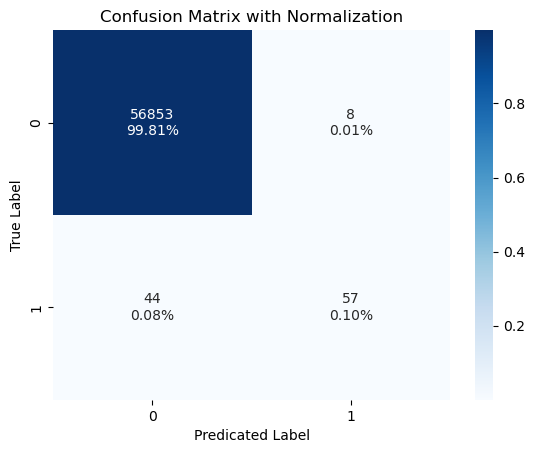

Accuracy (R^2) of Train Dataset:  0.9991485439662928
Accuracy (R^2) of Test Dataset:  0.9990871107053826
Accuracy score overall:  0.9990871107053826
Recall score is 56.44%

Logistic Regression with using smote
Classification accuracy is: 
 [[9.63554650e-01 3.46722376e-02]
 [2.10666760e-04 1.56244514e-03]]
Confusion Matrix is: 
 [[54886  1975]
 [   12    89]]
Classification report is: 
               precision    recall  f1-score   support

           0       1.00      0.97      0.98     56861
           1       0.04      0.88      0.08       101

    accuracy                           0.97     56962
   macro avg       0.52      0.92      0.53     56962
weighted avg       1.00      0.97      0.98     56962



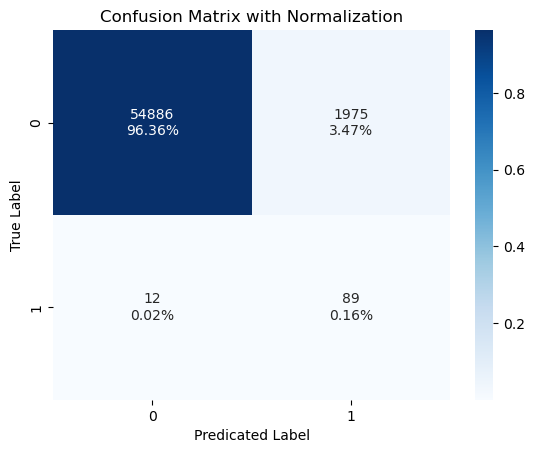

Validation test results:
Test Score: 0.9656437625083389
Accuracy Score: 0.9656437625083389
Recall Score: 0.8387096774193549

Test Results:
Test Score: 0.9651170956075981
Accuracy Score: 0.9651170956075981
Recall Score: 0.8811881188118812


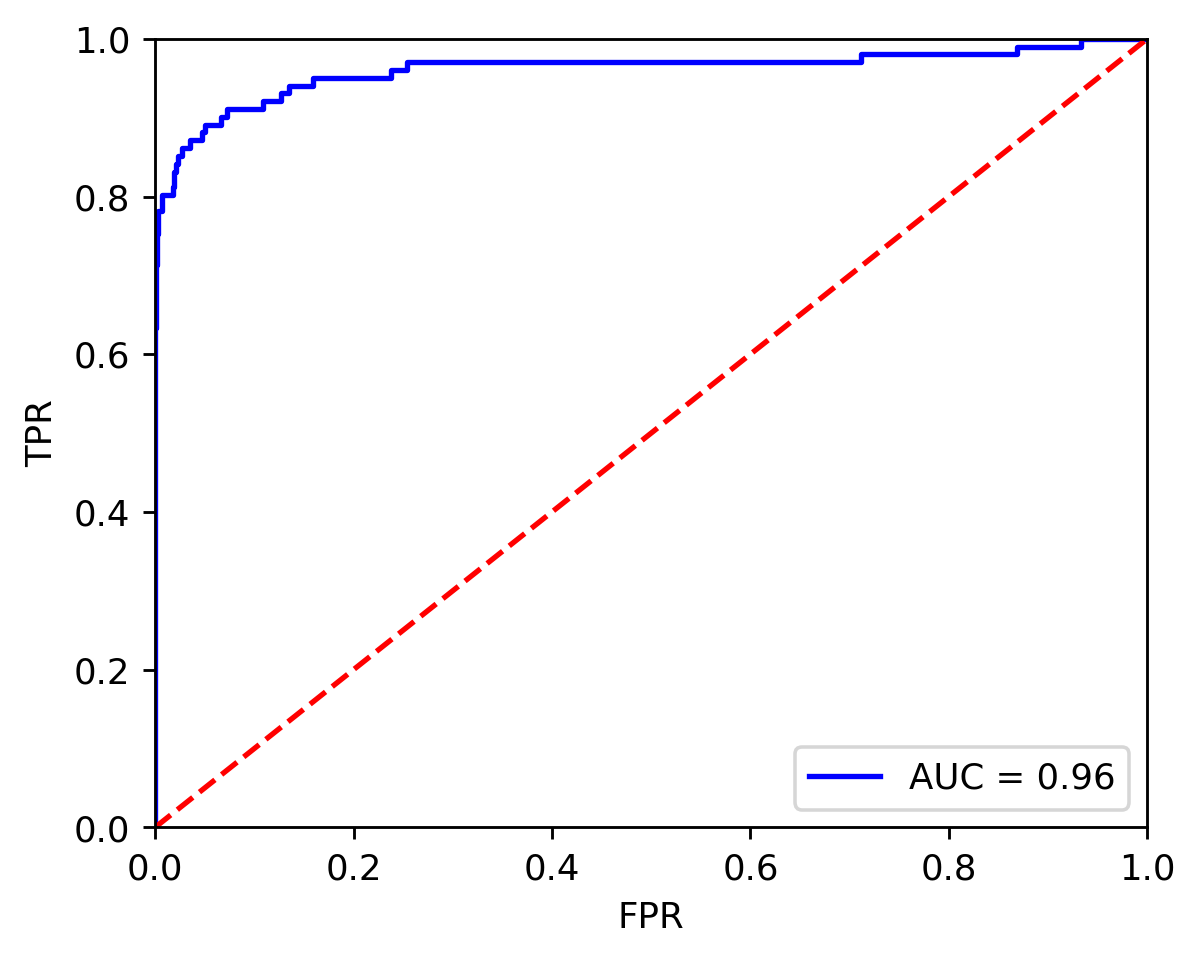

In [40]:
# Case 1: without standardization
no_stand_X_features = X.columns
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr_name = 'Logistic Regression'

y_pred_lr, y_pred_proba_lr, y_pred_smote_lr, y_pred_proba_smote_lr = model(no_stand_X_features, lr, lr_name)
ROC(np.array(y_test), y_pred_lr, y_pred_proba_lr, 'LR')

In [29]:
np.array(y_test)

array([0, 0, 0, ..., 0, 0, 0])

In [30]:
y_pred_lr

array([0, 0, 0, ..., 0, 0, 0])

In [31]:
y_pred_proba_lr

array([[9.99883787e-01, 1.16213221e-04],
       [9.99984538e-01, 1.54622353e-05],
       [9.99953132e-01, 4.68676891e-05],
       ...,
       [9.98595826e-01, 1.40417365e-03],
       [9.99579257e-01, 4.20742712e-04],
       [9.99922059e-01, 7.79405241e-05]])

In [32]:
y_pred_smote_lr

array([0, 0, 0, ..., 0, 0, 0])

In [33]:
y_pred_proba_smote_lr

array([[0.98883638, 0.01116362],
       [0.99652467, 0.00347533],
       [0.96329382, 0.03670618],
       ...,
       [0.9518836 , 0.0481164 ],
       [0.94539394, 0.05460606],
       [0.99578611, 0.00421389]])

Logistic Regression without using smote
Classification accuracy is: 
 [[9.98068888e-01 1.58000070e-04]
 [6.49555844e-04 1.12355605e-03]]
Confusion Matrix is: 
 [[56852     9]
 [   37    64]]
Classification report is: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.88      0.63      0.74       101

    accuracy                           1.00     56962
   macro avg       0.94      0.82      0.87     56962
weighted avg       1.00      1.00      1.00     56962



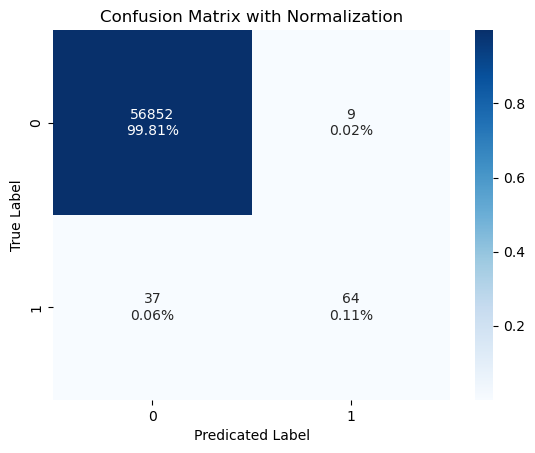

Accuracy (R^2) of Train Dataset:  0.9991968224011938
Accuracy (R^2) of Test Dataset:  0.9991924440855307
Accuracy score overall:  0.9991924440855307
Recall score is 63.37%

Logistic Regression with using smote
Before performing smote :  Counter({0: 170592, 1: 291})
After performing smote :  Counter({0: 170592, 1: 170592})
Classification accuracy is: 
 [[9.69909764e-01 2.83171237e-02]
 [7.02222534e-05 1.70288965e-03]]
Confusion Matrix is: 
 [[55248  1613]
 [    4    97]]
Classification report is: 
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     56861
           1       0.06      0.96      0.11       101

    accuracy                           0.97     56962
   macro avg       0.53      0.97      0.55     56962
weighted avg       1.00      0.97      0.98     56962



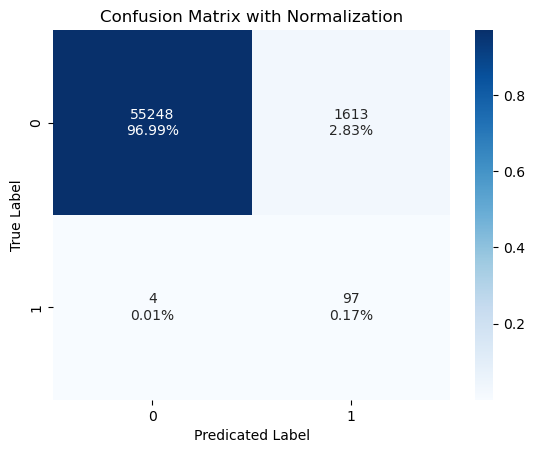

Validation test results:
Test Score: 0.9709630982058214
Accuracy Score: 0.9709630982058214
Recall Score: 0.94

Test Results:
Test Score: 0.9716126540500685
Accuracy Score: 0.9716126540500685
Recall Score: 0.9603960396039604


In [17]:
# Case 2: with standardization
stand_X_features = [i+'_stand' for i in X.columns]

model(stand_X_features, lr, lr_name)

## Random Forest

In [ ]:
print('Random Forest without using smote')
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)
rf_y_pred

In [ ]:
confusion_matrix(y_test, rf_y_pred)
# Accuracy
print("Accuracy (R^2) of Train Dataset: ", lr_model.score(X_train, y_train))
print("Accuracy (R^2) of Test Dataset: ", lr_model.score(X_test, y_test))
# Prediction Distribution 
print('Prediction that is classfied as 1 takes up', '{}%'.format(round(list(Counter(rf_y_pred).values())[1]/ sum(list(Counter(rf_y_pred).values())) * 100, 4)))

print('\n Random Forest with using smote')
rf_smote_model = RandomForestClassifier(random_state=42)
rf_smote = rf_smote_model.fit(X_train_smote, y_train_smote)
rf_smote_pred = rf_smote.predict(X_test_smote)

confusion_matrix(y_test_smote, rf_smote_pred)
# Accuracy
print("Accuracy (R^2) of Train Dataset: ", rf_smote_model.score(X_train_smote, y_train_smote))
print("Accuracy (R^2) of Test Dataset: ", rf_smote_model.score(X_test_smote, y_test_smote))
# Prediction Distribution 
print('Prediction that is classfied as 1 takes up', '{}%'.format(round(list(Counter(rf_smote_pred).values())[1]/ sum(list(Counter(rf_smote_pred).values())) * 100, 4)))

In [ ]:
print('Random Forest without using smote')
rf = RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
CV_rf.fit(X_train, y_train)
rf_best_para = CV_rf.best_params_

In [ ]:
print('Random Forest without using smote')
rf = RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
CV_rf.fit(X_train, y_train)
rf_best_para = CV_rf.best_params_

rf_best = RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 200, max_depth=8, criterion='gini')


self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)

rf.GridSearchCV(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = y_train)
rf_y_pred = rf.grid_predict(X_test, y_test)

confusion_matrix(y_test, rf_y_pred)
# Accuracy
print("Accuracy (R^2) of Train Dataset: ", lr_model.score(X_train, y_train))
print("Accuracy (R^2) of Test Dataset: ", lr_model.score(X_test, y_test))
# Prediction Distribution 
print('Prediction that is classfied as 1 takes up', '{}%'.format(round(list(Counter(rf_y_pred).values())[1]/ sum(list(Counter(rf_y_pred).values())) * 100, 4)))

print('\n Logistic Regression with using smote')
rf_smote_model = RandomForestClassifier(param_grid)
rf_smote = rf_smote_model.fit(X_train_smote, y_train_smote)
rf_smote_pred = rf_smote.predict(X_test_smote)

confusion_matrix(y_test_smote, rf_smote_pred)
# Accuracy
print("Accuracy (R^2) of Train Dataset: ", rf_smote_model.score(X_train_smote, y_train_smote))
print("Accuracy (R^2) of Test Dataset: ", rf_smote_model.score(X_test_smote, y_test_smote))
# Prediction Distribution 
print('Prediction that is classfied as 1 takes up', '{}%'.format(round(list(Counter(rf_smote_pred).values())[1]/ sum(list(Counter(rf_smote_pred).values())) * 100, 4)))